**How to run the file ?**  
After uploading the corpus, just run all the cells one by one.
The batch size has to be set while splitting the dataset to train, validation and test sets.

In [121]:
import torch
import torchtext
from torchtext import data
import matplotlib.pyplot as plt
import torch.optim as optim
import argparse
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import tensorflow as tf


In [122]:
df = pd.read_csv('/content/data.tsv', sep="\t")

In [123]:
display(df)

,text,label
0,"smart and alert , thirteen conversations about...",1
1,"color , musical bounce and warm seas lapping o...",1
2,it is not a mass-market entertainment but an u...,1
3,a light-hearted french film about the spiritua...,1
4,my wife is an actress has its moments in looki...,1
...,...,...
9995,"in the end , they discover that balance in lif...",0
9996,a counterfeit 1000 tomin bank note is passed i...,0
9997,enter the beautiful and mysterious secret agen...,0
9998,after listening to a missionary from china spe...,0


In [124]:
X = df['text']
y = df['label']

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,stratify=y)

In [126]:
X_train,X_val,y_train,y_val = train_test_split(X_train, y_train, test_size=0.20,stratify=y_train)

In [127]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(6400,)
(1600,)
(2000,)


In [128]:
z, v = y_train.value_counts()
print(z)
print(v)

3200
3200


In [129]:
def verify_split_count(x):
  x_count, y_count = x.value_counts()
  if(x_count == y_count):
    return "Satisfied"
  else:
    return "Failed"


In [130]:
print(verify_split_count(y_train))
print(verify_split_count(y_test))
print(verify_split_count(y_val))

Satisfied
Satisfied
Satisfied


In [131]:
def create_overfit_set():
  condition_positive = df['label'] == 1
  condition_negative = df['label'] == 0

  positive_set = df[condition_positive].sample(n = 25)
  negative_set = df[condition_negative].sample(n = 25)

  sample_set = [positive_set,negative_set]
  overfit_set = pd.concat(sample_set)
  return overfit_set

In [132]:
overfit_dataset = create_overfit_set()

In [133]:
def check_is_unique(df_1,df_2):
  check_df = df_1.to_frame().merge(df_2, how = "inner",indicator=False)
  if check_df.size == 0:
    return "No duplicate rows"
  else:
    return "Duplicate rows found"


In [134]:
check_is_unique(X_train,X_test)

'No duplicate rows'

In [135]:
train_dataset = pd.concat([X_train, y_train], axis=1)
val_dataset = pd.concat([X_val, y_val], axis=1)
test_dataset = pd.concat([X_test, y_test], axis=1)


In [136]:
train_dataset.to_csv("train.tsv", sep="\t")
val_dataset.to_csv("validation.tsv", sep="\t")
test_dataset.to_csv("test.tsv", sep="\t")
overfit_dataset.to_csv("overfit.tsv", sep="\t")

In [137]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, split="train"):
        data_path = "/content/"
        fullpath = os.path.join(data_path, f"{split}.tsv")
        # print(fullpath)
        df = pd.read_csv(os.path.join(data_path, f"{split}.tsv"), sep="\t")

        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            L = row["text"].split()
            X.append(torch.tensor([vocab.stoi.get(w, V-1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row.label)
        self.X = X 
        self.Y = torch.tensor(Y)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx] 

In [138]:
def my_collate_function(batch, device):
    # Handle the padding here
    # batch is approximately: [dataset[i] for i in range(0, batch_size)]
    # Since the dataset[i]'s contents is defined in the __getitem__() above, this collate function 
    # should be set correspondingly.
    # Also: collate_function just takes one argument. To pass in additional arguments (e.g., device), 
    # we need to wrap up an anonymous function (using lambda below)
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)

In [139]:
batch_size = 4
#   fix seed
torch.manual_seed(2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ("Using device:", device)

### 3.3 Processing of the data ###
# 3.3.1
# The first time you run this will download a 862MB size file to .vector_cache/glove.6B.zip
glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100
                                
# # 3.3.2

train_dataset = TextDataset(glove, "train")
val_dataset = TextDataset(glove, "validation")
test_dataset = TextDataset(glove, "test")
overfit_dataset = TextDataset(glove, "overfit")
    
# # 3.3.3
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=lambda batch: my_collate_function(batch, device))

validation_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=lambda batch: my_collate_function(batch, device))

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=lambda batch: my_collate_function(batch, device))
    
overfit_dataloader = torch.utils.data.DataLoader(
    dataset=overfit_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=lambda batch: my_collate_function(batch, device))
    
    # for item in train_dataloader:
    #   print(item)
    #   break

Using device: cpu


In [140]:
class baselineModel(torch.nn.Module):
      def __init__(self, vocab, emdedding_size):
        super(baselineModel,self).__init__()
        self.embedding = torch.nn.Embedding.from_pretrained(vocab.vectors)
        self.linear = torch.nn.Linear(emdedding_size,1)
      def forward(self, x):
        embedded_result = self.embedding(x)
        average_result = torch.mean(embedded_result,0)
        prediction = self.linear(average_result)
        # print(prediction.shape)
        return prediction


In [141]:
def train_baseline_model_overfit(dataloader, embedding_size):
    BATCH_SIZE = 4
    epoch = 50
    
    learning_rate = 0.2
    train_set_loss = []
    test_set_loss = []
    t_accuracy = []
    v_accuracy = []
    val_set_loss = []
    val_loss = 0.0
    model = baselineModel(glove,embedding_size)
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(),learning_rate)
    print("Training Started ----->")
    iterations = np.arange(0,epoch)
    for epoch in range(epoch):
      train_loss = 0.0

      model.train()
      n1=0
      train_accuracy = 0.0
      for text,label in (iter(dataloader)):
        
        prediction = model(text)
        prediction = prediction.squeeze(1)
        label = label.type(torch.float)
        # prediction = torch.reshape(prediction,(1,4))
        # print(prediction)
        # print(label)
        loss = criterion(prediction,label)
        loss.backward()
        optimizer.step()
        # print("Prediction shape--->",prediction.shape)
        # print("Prediction shape--->",label.unsqueeze(0))
        accuracy = ((prediction>0.5)==label).float().sum()
        train_accuracy = train_accuracy + accuracy/batch_size
        # print("train_accuracy--->",train_accuracy)
        optimizer.zero_grad()
        train_loss = train_loss + (float(loss))
        n1= n1+1
      train_set_loss.append(train_loss/n1)
      t_accuracy.append(train_accuracy/n1)

      model.eval()
      with torch.no_grad():
        val_loss = 0.0
        val_accuracy = 0.0
        n2=0
        for text,label in iter(dataloader):
          prediction = model(text)
          prediction = prediction.squeeze(1)
          label = label.type(torch.float)
          accuracy = ((prediction>0.5)==label).float().sum()
          val_accuracy = val_accuracy + (accuracy/BATCH_SIZE)
          # print(val_accuracy)
          loss = criterion(prediction,label)
          val_loss = val_loss + (float(loss)/BATCH_SIZE)
          n2= n2+1
        val_set_loss.append(val_loss/n2)
        v_accuracy.append(val_accuracy/n2)
        # print(v_accuracy)

      print("Epoch [{}], overfit_dataset_loss: {:.4f}, Accuracy: {:.4f}".format(epoch,train_set_loss[-1],t_accuracy[-1]))

    plt.title("Accuracy curve for Baseline model - Overfit Dataset")
    plt.plot(iterations,t_accuracy,label = "Training")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()    

    plt.title("Loss curve for Baseline model - Overfit Dataset")
    plt.plot(iterations,train_set_loss,label = "Overfit")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show() 

    return model

Training Started ----->
Epoch [0], overfit_dataset_loss: 4.8771, Accuracy: 0.4423
Epoch [1], overfit_dataset_loss: 4.8861, Accuracy: 0.4423
Epoch [2], overfit_dataset_loss: 0.6117, Accuracy: 0.7500
Epoch [3], overfit_dataset_loss: 2.9104, Accuracy: 0.1346
Epoch [4], overfit_dataset_loss: 1.0884, Accuracy: 0.5192
Epoch [5], overfit_dataset_loss: 0.5472, Accuracy: 0.7308
Epoch [6], overfit_dataset_loss: 0.6919, Accuracy: 0.6154
Epoch [7], overfit_dataset_loss: 0.9362, Accuracy: 0.5192
Epoch [8], overfit_dataset_loss: 0.8410, Accuracy: 0.5577
Epoch [9], overfit_dataset_loss: 0.5773, Accuracy: 0.6346
Epoch [10], overfit_dataset_loss: 0.4320, Accuracy: 0.7500
Epoch [11], overfit_dataset_loss: 0.4490, Accuracy: 0.7115
Epoch [12], overfit_dataset_loss: 0.4951, Accuracy: 0.6731
Epoch [13], overfit_dataset_loss: 0.4775, Accuracy: 0.7308
Epoch [14], overfit_dataset_loss: 0.4062, Accuracy: 0.7885
Epoch [15], overfit_dataset_loss: 0.3434, Accuracy: 0.8077
Epoch [16], overfit_dataset_loss: 0.3198, 

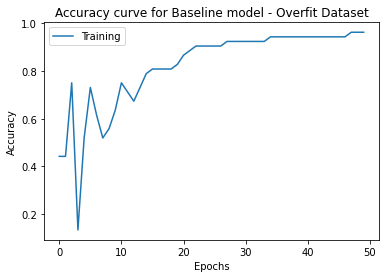

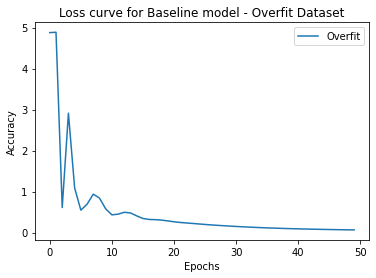

baselineModel(
  (embedding): Embedding(400000, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [142]:
train_baseline_model_overfit(overfit_dataloader,100)

In [143]:
def train_baseline_model(dataloader, embedding_size):
    BATCH_SIZE = 4
    epoch = 50
    
    learning_rate = 0.001
    train_set_loss = []
    test_set_loss = []
    t_accuracy = []
    v_accuracy = []
    val_set_loss = []
    val_loss = 0.0
    model = baselineModel(glove,embedding_size)
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(),learning_rate)
    print("Training Started ----->")
    iterations = np.arange(0,epoch)
    for epoch in range(epoch):
      train_loss = 0.0

      model.train()
      n1=0
      train_accuracy = 0.0
      for text,label in (iter(dataloader)):
        
        prediction = model(text)
        prediction = prediction.squeeze(1)
        label = label.type(torch.float)
        # prediction = torch.reshape(prediction,(1,4))
        # print(prediction)
        # print(label)
        loss = criterion(prediction,label)
        loss.backward()
        optimizer.step()
        # print("Prediction shape--->",prediction.shape)
        # print("Prediction shape--->",label.unsqueeze(0))
        accuracy = ((prediction>0.5)==label).float().sum()
        train_accuracy = train_accuracy + accuracy/batch_size
        # print("train_accuracy--->",train_accuracy)
        optimizer.zero_grad()
        train_loss = train_loss + (float(loss))
        n1= n1+1
      train_set_loss.append(train_loss/n1)
      t_accuracy.append(train_accuracy/n1)

      model.eval()
      with torch.no_grad():
        val_loss = 0.0
        val_accuracy = 0.0
        n2=0
        for text,label in iter(dataloader):
          prediction = model(text)
          prediction = prediction.squeeze(1)
          label = label.type(torch.float)
          accuracy = ((prediction>0.5)==label).float().sum()
          val_accuracy = val_accuracy + (accuracy/BATCH_SIZE)
          loss = criterion(prediction,label)
          val_loss = val_loss + (float(loss)/BATCH_SIZE)
          n2= n2+1
        val_set_loss.append(val_loss/n2)
        v_accuracy.append(val_accuracy/n2)

      print("Epoch [{}], train_loss: {:.4f}, Accuracy: {:.4f}".format(epoch,train_set_loss[-1],t_accuracy[-1]))

    plt.title("Accuracy curve for Baseline model")
    plt.plot(iterations,t_accuracy,label = "Training")
    plt.plot(iterations,v_accuracy,label = "Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()  

    plt.title("Loss curve for Baseline model")
    plt.plot(iterations,train_set_loss,label = "Training")
    plt.plot(iterations,val_set_loss,label = "Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show() 


    return model

Training Started ----->
Epoch [0], train_loss: 0.6053, Accuracy: 0.5466
Epoch [1], train_loss: 0.4929, Accuracy: 0.7262
Epoch [2], train_loss: 0.4355, Accuracy: 0.7920
Epoch [3], train_loss: 0.4015, Accuracy: 0.8186
Epoch [4], train_loss: 0.3793, Accuracy: 0.8317
Epoch [5], train_loss: 0.3636, Accuracy: 0.8397
Epoch [6], train_loss: 0.3520, Accuracy: 0.8458
Epoch [7], train_loss: 0.3429, Accuracy: 0.8506
Epoch [8], train_loss: 0.3356, Accuracy: 0.8545
Epoch [9], train_loss: 0.3296, Accuracy: 0.8586
Epoch [10], train_loss: 0.3245, Accuracy: 0.8608
Epoch [11], train_loss: 0.3202, Accuracy: 0.8623
Epoch [12], train_loss: 0.3165, Accuracy: 0.8642
Epoch [13], train_loss: 0.3132, Accuracy: 0.8661
Epoch [14], train_loss: 0.3102, Accuracy: 0.8678
Epoch [15], train_loss: 0.3076, Accuracy: 0.8694
Epoch [16], train_loss: 0.3053, Accuracy: 0.8706
Epoch [17], train_loss: 0.3031, Accuracy: 0.8719
Epoch [18], train_loss: 0.3011, Accuracy: 0.8727
Epoch [19], train_loss: 0.2994, Accuracy: 0.8731
Epoch 

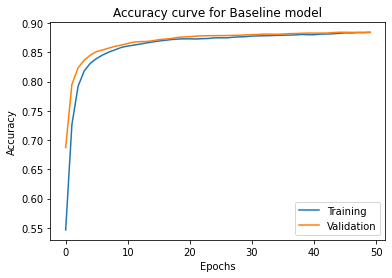

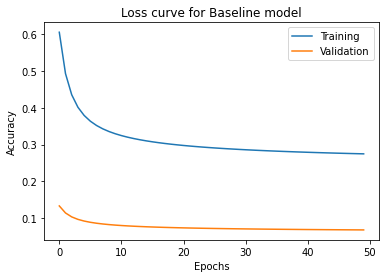

In [144]:
model = train_baseline_model(train_dataloader,100)

In [145]:
#test set

def evaluate(dataloader):
  BATCH_SIZE = 4
  epoch = 50
  iterations = np.arange(0,epoch)
  criterion = torch.nn.BCEWithLogitsLoss()
  learning_rate = 0.001
  train_set_loss = []
  test_set_loss = []
  t_accuracy = []
  v_accuracy = []
  val_set_loss = []
  val_loss = 0.0
  model.eval()
  with torch.no_grad():
    val_loss = 0.0
    val_accuracy = 0.0
    n2=0
    for text,label in iter(dataloader):
      prediction = model(text)
      prediction = prediction.squeeze(1)
      label = label.type(torch.float)
      accuracy = ((prediction>0.5)==label).float().sum()
      val_accuracy = val_accuracy + (accuracy/BATCH_SIZE)
      # print(val_accuracy)
      loss = criterion(prediction,label)
      val_loss = val_loss + (float(loss)/BATCH_SIZE)
      n2= n2+1
    val_set_loss.append(val_loss/n2)
    v_accuracy.append(val_accuracy/n2)
  print("test_loss: {:.4f}, test_accuracy: {:.4f}".format(val_set_loss[-1],v_accuracy[-1]))
  

In [146]:
evaluate(test_dataloader)

test_loss: 0.0675, test_accuracy: 0.8855


In [147]:
parameters = list(model.parameters())

In [148]:
vec = parameters[1].detach()

In [149]:
def print_closest_cosine_words(vec, n=5):
    cosine = torch.nn.CosineSimilarity(dim=2)
    dists = cosine(glove.vectors.unsqueeze(0), vec.unsqueeze(0))
    dists = dists.squeeze(0)
    lst = sorted(enumerate(dists.numpy()), key=lambda x: x[1], reverse = True) 
    for idx, difference in lst[1:n+1]:                         
        print(glove.itos[idx], "\t%5.2f" % difference)

In [150]:
print_closest_cosine_words(vec, n=20)

watchable 	 0.52
pleasing 	 0.52
flattering 	 0.51
campy 	 0.51
visuals 	 0.50
underwhelming 	 0.50
simplistic 	 0.50
laughable 	 0.49
verbiage 	 0.49
funnily 	 0.48
emptier 	 0.48
suspenseful 	 0.48
riveting 	 0.48
hokum 	 0.48
uninspired 	 0.48
mesmerizing 	 0.48
engrossing 	 0.48
appetizing 	 0.48
cartoony 	 0.48
nuanced 	 0.47


In [151]:
torch.save(model.state_dict(), 'model baseline.pt')

**Q 4.5**

**In the baseline model, what information contained in the original sentence is being ignored?**

In the baseline model, the order or the position of the words in the sentence is being ignored, this is because we directly take the average and in this case, the position is not considered at all.


**Q 4.6**  

**Use that function to determine the 20 closest words to that vector. You should see some words that make it clear what the classifier is doing. Do some of the words that you generated make sense?**  

From the generated weights, when we tried to get the 20 words closer to those weights, we got words like Watchable, Pleasing, underwhelming, simplistic which are basically words found in the movie review and description. From these words we can how classifier is finding the keywords in the sentences. 